In [1]:
from helpers import *
# from structure import UmbrellaGrid

In [2]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [3]:
import numpy as np

In [4]:
sys.path.append('../UmbrellaGen')
import grid_gen

In [5]:
import os
python_file_name = 'not_grid'

path_name = 'images/'+python_file_name
if not os.path.exists(path_name): os.makedirs(path_name)
# else: raise ValueError(f'folder {path_name} already exists')

### **Rows** and **Columns**

In [6]:
degree = 3
rows = 3
cols = 3
folfer_name='test00'
deployment = 'min'

In [7]:
minHeight = 64

In [8]:
import mesh
base_mesh = mesh.Mesh("../../data/plane_equi.obj")
V, F = base_mesh.vertices(), base_mesh.elements()
V_3d = np.zeros((len(V), 3))
V_3d[:, :2] = V
edge_length = np.linalg.norm(V_3d[F][0, 0] - V_3d[F][0, 1])
numUmbrellas = len(F)

In [9]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        # heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        heights[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
    heights = [h/min(heights) for h in heights]
    return heights

In [10]:
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = [1]*numUmbrellas,minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()), edge_length=edge_length)
# grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()), edge_length=edge_length)

In [11]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6), use_target_surface = False)
# Can set use_target_surface = True to add target_mesh to the curr_um class for target attraction during deployment as well as inverse design

In [12]:
init_center_pos = get_center_position(curr_um)
init_heights = curr_um.umbrellaHeights

In [13]:
folder_name = f'{degree:0>2}_{rows:0>2}_{cols:0>2}_{deployment}_{folfer_name}'
path_name += f'/{folder_name}'

### **Deployed** and **Undeployed**

In [14]:
deployed_cells  = [0,1,2, 76,77,78,79,80]
undeployed_cells = list(range(31,45))

- grid.border()
- grid.center()
- grid.vline(line_idx)
- grid.hline(line_idx)
- grid.cross(arm_length)

---

In [15]:
active_cells    = deployed_cells + undeployed_cells
target_percents = [100]*len(deployed_cells) + [0]*len(undeployed_cells) # 0:undeployed | 100:deployed

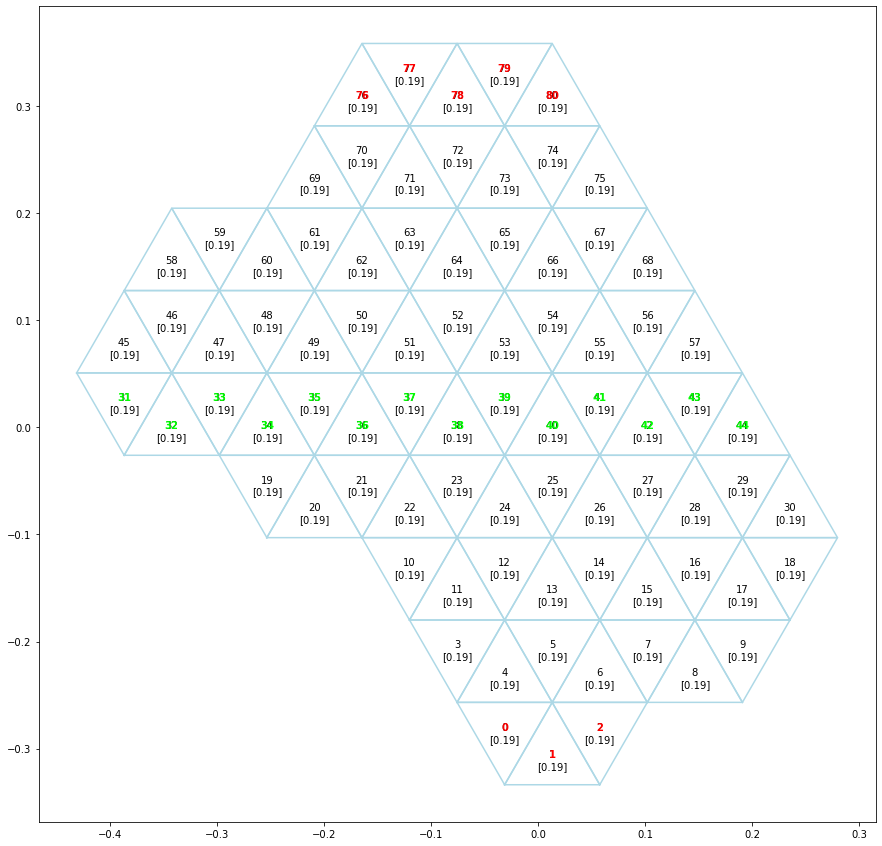

In [16]:
plot2D(input_data, curr_um, True, active_cells=active_cells, target_percents=target_percents)

In [17]:
view3D = plot3D(curr_um, input_data)
view3D.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [18]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False)

In [19]:
dep_weights              = set_actives_dep_weights(numUmbrellas, active_cells)
target_heights           = percent_to_height(init_heights, plate_thickness_scaled, active_cells, target_percents)
target_height_multiplier = set_target_height(numUmbrellas, active_cells, target_heights)

In [20]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, target_height_multiplier, view3D, rod_colors, analysis = True, dep_weights=np.logspace(-4, 0, 5))

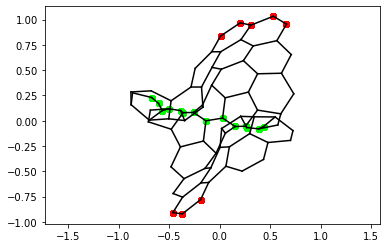

In [21]:
projection2D(input_data, curr_um, active_cells=active_cells, target_percents=target_percents)

In [22]:
sview_vm = plot3D_stress(curr_um, 'maxBending')
sview_vm.show()

maxBending Stresses Extrem values:
    max : 2.02e+02
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

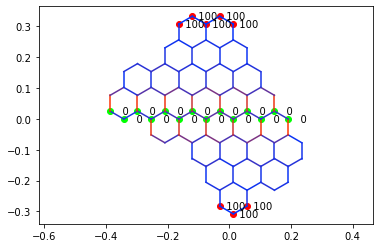

In [23]:
plot2D_stress(curr_um, input_data, init_center_pos, active_cells, target_percents, show_percent=True)

### **Step Deployments**

In [24]:
stresses_per_steps, percents_per_steps = \
deploy_in_steps(curr_um,
                input_data,
                init_heights,
                plate_thickness_scaled,
                active_cells,
                target_percents,
                steps=2,
                stress_type='maxBending',
                verbose=True,
                dep=deployment)

step  0/2 computed.
step  1/2 computed.
step  2/2 computed.


### **Save images**

In [25]:
plot2D_steps(input_data,
             active_cells,
             percents_per_steps,
             init_center_pos,
             stresses_per_steps,
             stress_type='maxBending',
             dir_name=path_name,
             show_percent=False,
             show_plot=False)

### **Create GIF**

In [26]:
img_name = f'"{path_name}/'+'*{}*.jpg"'
gif_name = f'"{path_name}/'+'{}.gif"'
fps  = 5 # frames per seconds
loop = 2 # -1: no loop | 0: infinit loop | 1: loop once (see image twice) | 2: loop twice | ...
for name in ['structure_all', 'structure_perSteps', 'structure_own', 'scatter', 'sPlot']:
    img_name_i = img_name.format(name)
    gif_name_i = gif_name.format(name)
    !ffmpeg  -loglevel panic -f image2 -r $fps -pattern_type glob -i $img_name_i -loop $loop $gif_name_i